## Dev Dashboarding ##
panel serve PHNX_prod_analytics.ipynb --session-token-expiration 600
* https://docs.google.com/document/d/1PU1OUlR6i1fGRnLsv8iYXmmY_byGu2kccWzCMyY922o/edit

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import panel as pn
import pickle
import numpy as np
cwd = os.getcwd()
slash_idx = [i for i,l in enumerate(cwd) if l=='/']
repo_dir = cwd[:slash_idx[-2]]
sys.path.append(repo_dir)
from analysis.analysis_pipeline import AnalysisPipeline
from utils.lims_utils import get_plate_runs, plates_from_exp, plates_from_workflow
from utils.s3_interface import download_from_s3, upload_to_s3, s3_imgupload, s3_df2csv, s3_csv2df, s3_imgdownload
from utils.table_properties import * 
pd.set_option('display.max_columns', None)
s3_bucket = 'ml-analytics-file-store' 

dataset_folder = '../../../DATASETS/'
figure_folder = '../../../FIGURES/'
pn.extension(sizing_mode="stretch_width")

overall_analytics_panel = []
variant_analytics_panel = []
top_variant_reps = []
top_variant_analytics_panel = []
activity_corr_panel = []
activityCV_corr_panel = []
plate_analytics_panel = []
library_analytics_panel = []
unit_analytics_panel = []

# Get data from table

In [78]:
s3_subfolder = f'VQ-Retest5/' 
exp_workflow = ['WF10198']
table = 'combi_analytics_table' # 'lcms_detections' # 
# metric_dict = {'LcmsC18':['pellet_OD', 'measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)']}
metric_dict = {'LcmsC18':['measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)'], 'LcmsChiral':['measured_enantiomeric_excess_(+over-)']}
analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    metric_dict=metric_dict, 
    get_dashboard_panel=False,
    save_plots_to_s3=True,
    hit_filter_dict = {'measured_nonbinary_score_(r)': 5}
)
df = analysis_pipeline.load_data(table, exp_workflow=exp_workflow)
# df = analysis_pipeline.get_derived_metrics(df, derived_metrics_to_get=['LcmsC18', 'LcmsChiral'])
# df = analysis_pipeline.standardize_dataset_columns(df, data_type=table, update_analytics_table=False)

# save full table to S3
csv_fname = f'{table}_{"-".join(exp_workflow)}'
analysis_pipeline.save_content_to_s3(csv_fname, df, file_format='csv', content_header='FULL DATASET', content_type='dataframe')

executing query: SELECT "id", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "maldi_run", "lcms_C18_run", "lcms_chiral_run", "maldi_plate_(r)", "maldi_address_(r)", "lcms_plate_(r)", "lcms_address_(r)", "source_plate_(r)", "source_address_(r)", "maldi_plate_(+)", "maldi_address_(+)", "lcms_plate_(+)", "lcms_address_(+)", "source_plate_(+)", "source_address_(+)", "maldi_plate_(-)", "maldi_address_(-)", "lcms_plate_(-)", "lcms_address_(-)", "source_plate_(-)", "source_address_(-)", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "mutations", "hamming", "reference_enzyme", "substrate_barcode_(r)", "substrate_barcode_(+)", "substrate_barcode_(-)", "substrate_smiles_(r)", "substrate_smiles_(+)", "substrate_smiles_(-)", "substrate_concentration_(r)", "substrate_concentration_(+)", "substrate_concentration_(-)", "predicted_binary_score_(r)", "predicted_nonbinary_score_(r)", "measured_nonbinary_score_(r)", "measured_nonbinary_sum_(r)", "measured_conversio

## Data Cleanup + Update exp_condition labels on data

In [92]:
include_only_exp_ctrls = False
change_expcondition_labels_to_uppercase = False
remove_space_from_expcondition_labels = True
add_subconc_to_expcondition_labels = False
add_enzbarcode_to_expcondition_labels = True
add_plate_to_expcondition_labels = True
add_enzbarcode_to_plate_labels = False
clean_up_enzbarcode_labels = False
clean_up_mutstr_labels = False
update_ctrl_label = True

if include_only_exp_ctrls:
    # include only 'exp' type samples 
    df = df.loc[df.ctrl_type=='exp'].copy()

if change_expcondition_labels_to_uppercase:
    # clean up exp_condition labels
    exp_condition_list = df.exp_condition.tolist()
    exp_condition_list = [str(e).upper() for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_list
    print(set(df.exp_condition))
    
if remove_space_from_expcondition_labels:
    # clean up exp_condition labels
    exp_condition_list = df.exp_condition.tolist()
    exp_condition_list = [str(e).replace(' ','') for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_list
    print(set(df.exp_condition))

if add_subconc_to_expcondition_labels:
    # add substrate concentration to exp_condition labels
    sub_conc_list = [f'{str(int(sub_conc))}mM' for sub_conc in df['substrate_concentration_(r)'].tolist()]
    exp_condition_list = [f'{sub_conc}_{exp_condition}' for sub_conc, exp_condition in zip(sub_conc_list, exp_condition_list)]
    exp_condition_list = [str(e).upper().replace(' ','') for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_wsubconc_list
    print(set(df.exp_condition))
    
if clean_up_enzbarcode_labels:
    # clean up enzyme_barcode labels
    enz_list = df.enzyme_barcode.tolist()
    enz_list = [str(e) for e in enz_list]
    df.loc[:, 'enzyme_barcode'] = enz_list

if clean_up_mutstr_labels:
    # clean up mutation strings labels
    enz_list = df.mutations.tolist()
    enz_list = [str(e) for e in enz_list]
    df.loc[:, 'mutations'] = enz_list
    
if add_enzbarcode_to_expcondition_labels:
    # add enzyme barcode to exp_condition labels
    exp_condition_label = 'exp_condition'
    new_exp_condition_label = 'enzbarcode_expcondition'
    exp_condition_list = df[exp_condition_label].tolist()
    enz_list = [f'{str(enz_barcode)}' for enz_barcode in df['enzyme_barcode'].tolist()]
    new_exp_condition__list = [f'{enz_barcode}_{exp_condition}' for enz_barcode, exp_condition in zip(enz_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if add_plate_to_expcondition_labels:
    # add enzyme barcode to exp_condition labels
    exp_condition_label = 'enzbarcode_expcondition'
    new_exp_condition_label = 'plate_enzbarcode_expcondition'
    exp_condition_list = df[exp_condition_label].tolist()
    plate_list = [f'{str(plate)}' for plate in df['lcms_plate_(r)'].tolist()]
    new_exp_condition__list = [f'{plate}_{exp_condition}' for plate, exp_condition in zip(plate_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if add_plate_to_expcondition_labels:
    # add enzyme barcode to exp_condition labels
    exp_condition_label = 'exp_condition'
    new_exp_condition_label = 'plate_expcondition'
    exp_condition_list = df[exp_condition_label].tolist()
    plate_list = [f'{str(plate)}' for plate in df['lcms_plate_(r)'].tolist()]
    # new_exp_condition__list = [f'{plate}_{exp_condition}' for plate, exp_condition in zip(plate_list, exp_condition_list)]
    new_exp_condition__list = [f'{exp_condition}_{plate}' for plate, exp_condition in zip(plate_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if add_enzbarcode_to_plate_labels:
    # add enzyme barcode to plate labels
    exp_condition_label = 'lcms_plate_(r)'
    new_exp_condition_label = 'enzbarcode_plate'
    exp_condition_list = df[exp_condition_label].tolist()
    enz_list = [f'{str(enz_barcode)}' for enz_barcode in df['enzyme_barcode'].tolist()]
    new_exp_condition__list = [f'{enz_barcode}_{exp_condition}' for enz_barcode, exp_condition in zip(enz_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if update_ctrl_label: 
    # add dummy column to record control type
    ctrl_type_colname = 'ctrl_type_0'
    df.loc[df['enzyme_barcode']=='ENZ10045', ctrl_type_colname] = 'pos'
    df.loc[df['enzyme_barcode']=='DNA10001', ctrl_type_colname] = 'EV'
    df.loc[~df['enzyme_barcode'].isin(['DNA10001','ENZ10045']), ctrl_type_colname] = 'exp'
    print(sorted(list(set(df.ctrl_type))))

{'2h45minIncubation,MiniPrep', '2h45minIncubation,Seed', '2h45minIncubation,GlycerolStock', '16hIncubation,GlycerolStock', '16hIncubation,MiniPrep', '16hIncubation,Seed'}
['DNA10001_16hIncubation,GlycerolStock', 'DNA10001_16hIncubation,MiniPrep', 'DNA10001_16hIncubation,Seed', 'DNA10001_2h45minIncubation,GlycerolStock', 'DNA10001_2h45minIncubation,MiniPrep', 'DNA10001_2h45minIncubation,Seed', 'ENZ10045_16hIncubation,GlycerolStock', 'ENZ10045_16hIncubation,MiniPrep', 'ENZ10045_16hIncubation,Seed', 'ENZ10045_2h45minIncubation,GlycerolStock', 'ENZ10045_2h45minIncubation,MiniPrep', 'ENZ10045_2h45minIncubation,Seed', 'ENZ12714_16hIncubation,GlycerolStock', 'ENZ12714_16hIncubation,MiniPrep', 'ENZ12714_16hIncubation,Seed', 'ENZ12714_2h45minIncubation,GlycerolStock', 'ENZ12714_2h45minIncubation,MiniPrep', 'ENZ12714_2h45minIncubation,Seed', 'ENZ16228_16hIncubation,GlycerolStock', 'ENZ16228_16hIncubation,MiniPrep', 'ENZ16228_16hIncubation,Seed', 'ENZ16228_2h45minIncubation,GlycerolStock', 'ENZ16

## Save data locally

In [ ]:
df.to_csv(f'{dataset_folder}VQ-Retest5.csv')

# Get Analytics from data

In [93]:
# get experiment analytics metrics
experiment_analytics, experiment_analytics_panel = analysis_pipeline.GET_EXPERIMENT_ANALYTICS(df, exp_column='enzbarcode_expcondition', groupby=['ctrl_type_0', 'exp_condition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'], display_table=True)
variant_plate_analytics, variant_plate_analytics_panel = analysis_pipeline.GET_EXPERIMENT_ANALYTICS(df, exp_column='plate_enzbarcode_expcondition', groupby=['ctrl_type_0', 'exp_condition', 'plate_expcondition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'], display_table=True)
variant_analytics, variant_analytics_panel = analysis_pipeline.GET_VARIANT_ANALYTICS(df, display_table=True, plot_histogram=False, groupby=['enzyme_barcode', 'mutations', 'exp_condition', 'library_ref', 'substrate_concentration_(r)', 'exp_workflow_barcode', 'lcms_plate_(r)', 'lcms_address_(r)'])

*********************************
Computing Experiment Analytics...
*********************************
LcmsC18 ['measured_nonbinary_sum_(r)', 'measured_nonbinary_score_(r)', 'measured_conversion_(r)']
LcmsChiral ['measured_enantiomeric_excess_(+over-)']


,enzbarcode_expcondition,ctrl_type_0,exp_condition,enzyme_barcode,lcms_plate_(r),library_ref,n_LcmsC18,n_LcmsChiral,measured_nonbinary_sum_(r)_median,measured_nonbinary_sum_(r)_mean,measured_nonbinary_sum_(r)_max,measured_nonbinary_sum_(r)_min,measured_nonbinary_sum_(r)_cv,measured_nonbinary_sum_(r)_std,measured_nonbinary_sum_(r)_iqr,measured_nonbinary_sum_(r)_iqr_norm,measured_nonbinary_sum_(r)_range,measured_nonbinary_sum_(r)_range_norm,measured_nonbinary_score_(r)_median,measured_nonbinary_score_(r)_mean,measured_nonbinary_score_(r)_max,measured_nonbinary_score_(r)_min,measured_nonbinary_score_(r)_cv,measured_nonbinary_score_(r)_std,measured_nonbinary_score_(r)_iqr,measured_nonbinary_score_(r)_iqr_norm,measured_nonbinary_score_(r)_range,measured_nonbinary_score_(r)_range_norm,measured_nonbinary_score_(r)_nonhitrate,measured_conversion_(r)_median,measured_conversion_(r)_mean,measured_conversion_(r)_max,measured_conversion_(r)_min,measured_conversion_(r)_cv,measured_conversion_(r)_std,measured_conversion_(r)_iqr,measured_conversion_(r)_iqr_norm,measured_conversion_(r)_range,measured_conversion_(r)_range_norm,measured_enantiomeric_excess_(+over-)_median,measured_enantiomeric_excess_(+over-)_mean,measured_enantiomeric_excess_(+over-)_max,measured_enantiomeric_excess_(+over-)_min,measured_enantiomeric_excess_(+over-)_cv,measured_enantiomeric_excess_(+over-)_std,measured_enantiomeric_excess_(+over-)_iqr,measured_enantiomeric_excess_(+over-)_iqr_norm,measured_enantiomeric_excess_(+over-)_range,measured_enantiomeric_excess_(+over-)_range_norm
all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,64.000,64.000,208.791,208.453,225.798,186.210,0.043,8.935,12.156,0.058,39.588,0.190,-0.273,-0.257,0.360,-0.602,-1.170,0.301,0.528,-1.934,0.962,-3.523,NaN,-0.001,-0.001,0.002,-0.003,-1.168,0.001,0.003,-1.909,0.005,-3.379,0.004,0.003,0.032,-0.037,5.376,0.016,0.026,7.180,0.069,19.060
all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all exp ctrls (by enzbarcode_expcondition),NaN,NaN,NaN,NaN,NaN,NaN,30.609,30.609,197.108,196.688,215.039,177.720,0.045,8.726,10.645,0.054,37.319,0.190,87.962,89.502,118.493,38.561,0.361,20.018,22.895,5.375,79.932,-11.351,0.244,0.425,0.434,0.580,0.186,0.365,0.098,0.114,5.553,0.394,-10.749,0.102,0.104,0.289,-0.069,-0.641,0.081,0.090,4.384,0.358,39.951
0,"DNA10001_16hIncubation,GlycerolStock",EV,"16hIncubation,GlycerolStock",DNA10001,PLT18712,Negative_Control_OMNI_TRAY_LIBRARY,16.000,16.000,223.029,221.996,229.700,206.633,0.026,5.798,6.950,0.031,23.067,0.103,0.061,0.058,0.144,-0.061,0.913,0.053,0.045,0.736,0.205,3.385,1.000,0.000,0.000,0.001,-0.000,0.916,0.000,0.000,0.743,0.001,3.403,0.005,-0.000,0.019,-0.028,-96.278,0.015,0.025,4.679,0.047,8.746
1,"DNA10001_16hIncubation,MiniPrep",EV,"16hIncubation,MiniPrep",DNA10001,PLT18712,OMNI_TRAY_LIBRARY,32.000,32.000,217.117,216.804,232.986,201.197,0.034,7.441,10.503,0.048,31.788,0.146,-0.006,0.204,5.143,-0.085,4.471,0.911,0.110,-17.314,5.228,-819.601,0.969,-0.000,0.001,0.025,-0.000,4.476,0.004,0.001,-17.314,0.025,-798.223,-0.001,-0.003,0.021,-0.035,-5.988,0.016,0.027,-39.139,0.056,-82.499
2,"DNA10001_2h45minIncubation,GlycerolStock",EV,"2h45minIncubation,GlycerolStock",DNA10001,PLT18713,Negative_Control_OMNI_TRAY_LIBRARY,16.000,16.000,224.109,222.134,229.513,205.859,0.027,5.983,5.455,0.024,23.654,0.106,-0.513,-0.464,0.350,-0.574,-0.474,0.220,0.052,-0.102,0.925,-1.802,1.000,-0.002,-0.002,0.002,-0.003,-0.468,0.001,0.000,-0.105,0.004,-1.799,-0.001,0.001,0.025,-0.016,10.937,0.015,0.026,-17.521,0.041,-28.094
3,"DNA10001_2h45minIncubation,MiniPrep",EV,"2h45minIncubation,MiniPrep",DNA10001,PLT18713,OMNI_TRAY_LIBRARY,32.000,32.000,223.403,222.286,234.350,206.121,0.030,6.771,8.811,0.039,28.229,0.126,-0.538,-0.470,0.642,-0.614,-0

Saved VQ-Retest5/enzbarcode_expcondition_METRICS.csv to S3.
Obtained variant experiment metrics. 

*********************************
Computing Experiment Analytics...
*********************************
LcmsC18 ['measured_nonbinary_sum_(r)', 'measured_nonbinary_score_(r)', 'measured_conversion_(r)']
LcmsChiral ['measured_enantiomeric_excess_(+over-)']


,plate_enzbarcode_expcondition,ctrl_type_0,exp_condition,plate_expcondition,enzyme_barcode,lcms_plate_(r),library_ref,n_LcmsC18,n_LcmsChiral,measured_nonbinary_sum_(r)_median,measured_nonbinary_sum_(r)_mean,measured_nonbinary_sum_(r)_max,measured_nonbinary_sum_(r)_min,measured_nonbinary_sum_(r)_cv,measured_nonbinary_sum_(r)_std,measured_nonbinary_sum_(r)_iqr,measured_nonbinary_sum_(r)_iqr_norm,measured_nonbinary_sum_(r)_range,measured_nonbinary_sum_(r)_range_norm,measured_nonbinary_score_(r)_median,measured_nonbinary_score_(r)_mean,measured_nonbinary_score_(r)_max,measured_nonbinary_score_(r)_min,measured_nonbinary_score_(r)_cv,measured_nonbinary_score_(r)_std,measured_nonbinary_score_(r)_iqr,measured_nonbinary_score_(r)_iqr_norm,measured_nonbinary_score_(r)_range,measured_nonbinary_score_(r)_range_norm,measured_nonbinary_score_(r)_nonhitrate,measured_conversion_(r)_median,measured_conversion_(r)_mean,measured_conversion_(r)_max,measured_conversion_(r)_min,measured_conversion_(r)_cv,measured_conversion_(r)_std,measured_conversion_(r)_iqr,measured_conversion_(r)_iqr_norm,measured_conversion_(r)_range,measured_conversion_(r)_range_norm,measured_enantiomeric_excess_(+over-)_median,measured_enantiomeric_excess_(+over-)_mean,measured_enantiomeric_excess_(+over-)_max,measured_enantiomeric_excess_(+over-)_min,measured_enantiomeric_excess_(+over-)_cv,measured_enantiomeric_excess_(+over-)_std,measured_enantiomeric_excess_(+over-)_iqr,measured_enantiomeric_excess_(+over-)_iqr_norm,measured_enantiomeric_excess_(+over-)_range,measured_enantiomeric_excess_(+over-)_range_norm
all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,64.000,64.000,208.791,208.453,225.798,186.210,0.043,8.935,12.156,0.058,39.588,0.190,-0.273,-0.257,0.360,-0.602,-1.170,0.301,0.528,-1.934,0.962,-3.523,NaN,-0.001,-0.001,0.002,-0.003,-1.168,0.001,0.003,-1.909,0.005,-3.379,0.004,0.003,0.032,-0.037,5.376,0.016,0.026,7.180,0.069,19.060
all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all exp ctrls (by plate_enzbarcode_expcondition),NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.304,15.304,196.864,196.688,211.109,181.842,0.042,8.224,9.226,0.047,29.267,0.150,92.269,89.502,113.825,52.142,0.246,18.092,17.125,4.465,61.683,50.131,0.244,0.447,0.434,0.552,0.253,0.246,0.088,0.083,4.465,0.299,50.131,0.103,0.104,0.247,-0.031,0.746,0.076,0.081,1.021,0.277,3.797
0,"PLT18711_DNA10001_16hIncubation,GlycerolStock",EV,"16hIncubation,GlycerolStock","16hIncubation,GlycerolStock_PLT18711",DNA10001,PLT18711,Negative_Control_OMNI_TRAY_LIBRARY,8.000,8.000,226.131,225.511,229.700,218.835,0.015,3.319,3.389,0.015,10.865,0.048,0.073,0.073,0.144,-0.036,0.794,0.058,0.062,0.849,0.180,2.462,1.000,0.000,0.000,0.001,-0.000,0.794,0.000,0.000,0.849,0.001,2.462,-0.010,-0.007,0.013,-0.028,-2.401,0.016,0.024,-2.427,0.042,-4.206
1,"PLT18711_DNA10001_16hIncubation,MiniPrep",EV,"16hIncubation,MiniPrep","16hIncubation,MiniPrep_PLT18711",DNA10001,PLT18711,OMNI_TRAY_LIBRARY,16.000,16.000,220.387,219.346,232.986,208.791,0.032,6.931,10.181,0.046,24.194,0.110,-0.020,-0.015,0.097,-0.085,-3.137,0.049,0.063,-3.172,0.181,-9.102,1.000,-0.000,-0.000,0.000,-0.000,-3.137,0.000,0.000,-3.172,0.001,-9.102,-0.009,-0.003,0.021,-0.028,-6.396,0.017,0.027,-2.921,0.050,-5.289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,"PLT18714_ENZ35920_2h45minIncubation,MiniPrep",exp,"2h45minIncubation,MiniPrep","2h45minIncubation,MiniPrep_PLT18714",ENZ35920,PLT18714,OMNI_TRAY_LIBRARY,16.000,16.000,205.021,204.770,216.887,192.835,0.032,6.515,7.044,0.034,24.051,0.117,79.122,79.716,123.404,32.414,0.263,20.999,18.695,0.236,

Saved VQ-Retest5/plate_enzbarcode_expcondition_METRICS.csv to S3.
Obtained variant experiment metrics. 

******************************
Computing Variant Analytics...
******************************
LcmsC18 ['measured_nonbinary_sum_(r)', 'measured_nonbinary_score_(r)', 'measured_conversion_(r)']
LcmsChiral ['measured_enantiomeric_excess_(+over-)']


,enzyme_barcode,mutations,exp_condition,library_ref,substrate_concentration_(r),exp_workflow_barcode,lcms_plate_(r),lcms_address_(r),n_LcmsC18,n_LcmsChiral,measured_nonbinary_sum_(r)_median_EV,measured_nonbinary_sum_(r)_mean_EV,measured_nonbinary_sum_(r)_cv_EV,measured_nonbinary_sum_(r)_std_EV,measured_nonbinary_sum_(r)_iqr_EV,measured_nonbinary_sum_(r)_median,measured_nonbinary_sum_(r)_mean,measured_nonbinary_sum_(r)_max,measured_nonbinary_sum_(r)_min,measured_nonbinary_sum_(r)_cv,measured_nonbinary_sum_(r)_std,measured_nonbinary_sum_(r)_iqr,measured_nonbinary_sum_(r)_iqr_norm,measured_nonbinary_sum_(r)_range,measured_nonbinary_sum_(r)_range_norm,measured_nonbinary_score_(r)_median_EV,measured_nonbinary_score_(r)_mean_EV,measured_nonbinary_score_(r)_cv_EV,measured_nonbinary_score_(r)_std_EV,measured_nonbinary_score_(r)_iqr_EV,measured_nonbinary_score_(r)_median,measured_nonbinary_score_(r)_mean,measured_nonbinary_score_(r)_max,measured_nonbinary_score_(r)_min,measured_nonbinary_score_(r)_cv,measured_nonbinary_score_(r)_std,measured_nonbinary_score_(r)_iqr,measured_nonbinary_score_(r)_iqr_norm,measured_nonbinary_score_(r)_range,measured_nonbinary_score_(r)_range_norm,measured_nonbinary_score_(r)_nonhitrate,measured_conversion_(r)_median_EV,measured_conversion_(r)_mean_EV,measured_conversion_(r)_cv_EV,measured_conversion_(r)_std_EV,measured_conversion_(r)_iqr_EV,measured_conversion_(r)_median,measured_conversion_(r)_mean,measured_conversion_(r)_max,measured_conversion_(r)_min,measured_conversion_(r)_cv,measured_conversion_(r)_std,measured_conversion_(r)_iqr,measured_conversion_(r)_iqr_norm,measured_conversion_(r)_range,measured_conversion_(r)_range_norm,measured_enantiomeric_excess_(+over-)_median_EV,measured_enantiomeric_excess_(+over-)_mean_EV,measured_enantiomeric_excess_(+over-)_cv_EV,measured_enantiomeric_excess_(+over-)_std_EV,measured_enantiomeric_excess_(+over-)_iqr_EV,measured_enantiomeric_excess_(+over-)_median,measured_enantiomeric_excess_(+over-)_mean,measured_enantiomeric_excess_(+over-)_max,measured_enantiomeric_excess_(+over-)_min,measured_enantiomeric_excess_(+over-)_cv,measured_enantiomeric_excess_(+over-)_std,measured_enantiomeric_excess_(+over-)_iqr,measured_enantiomeric_excess_(+over-)_iqr_norm,measured_enantiomeric_excess_(+over-)_range,measured_enantiomeric_excess_(+over-)_range_norm
all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,64.000,64.000,NaN,NaN,NaN,NaN,NaN,208.791,208.453,225.798,186.210,0.043,8.935,12.156,0.058,39.588,0.190,NaN,NaN,NaN,NaN,NaN,-0.273,-0.257,0.360,-0.602,-1.170,0.301,0.528,-1.934,0.962,-3.523,NaN,NaN,NaN,NaN,NaN,NaN,-0.001,-0.001,0.002,-0.003,-1.168,0.001,0.003,-1.909,0.005,-3.379,NaN,NaN,NaN,NaN,NaN,0.004,0.003,0.032,-0.037,5.376,0.016,0.026,7.180,0.069,19.060
all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all exp ctrls (by enzyme_barcode),NaN,NaN,NaN,NaN,308.000,NaN,NaN,NaN,176.000,176.000,208.791,208.453,0.043,8.935,12.156,197.497,197.584,232.329,164.627,0.053,10.299,13.310,0.068,67.703,0.346,-0.273,-0.257,-1.170,0.301,0.528,78.631,85.771,147.695,7.693,-0.078,38.345,55.436,-0.228,140.002,-9.722,0.275,-0.001,-0.001,-1.168,0.001,0.003,0.381,0.416,0.728,0.037,-0.082,0.188,0.276,-0.188,0.691,-9.612,0.004,0.003,5.376,0.016,0.026,0.077,0.100,0.517,-0.213,2.139,0.107,0.115,2.047,0.729,14.225
0,ENZ34973,None,"16hIncubation,MiniPrep",OMNI_TRAY_LIBRARY,308.000,WF10198,PLT18712,X15Y1,192.000,192.000,NaN,NaN,NaN,NaN,NaN,187.041,187.066,280.814,165.203,0.059,10.981,11.889,0.064,115.611,0.618,NaN,NaN,NaN,NaN,NaN,187.273,183.879,219.565,0.749,0.114,20.933,12.509,0.067,218.816,1.168,0.005,NaN,NaN,N

Saved VQ-Retest5/enzyme_METRICS.csv to S3.
Obtained variant analytics metrics. 



## Get scatter plots of Chiral metric vs. C18 metric

Saved VQ-Retest5/SCATTERPLOT_ChiralEE-MEDIAN-vs-RacemicProdConc-MEDIAN_ctrl_type_0.png to S3.
Saved VQ-Retest5/SCATTERPLOT_ChiralEE-vs-RacemicProdConc_enzyme_barcode.png to S3.


[<Figure size 360x360 with 1 Axes>]

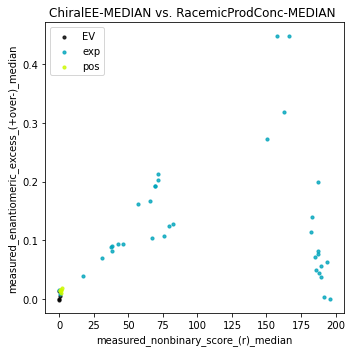

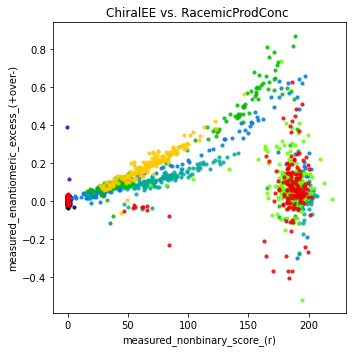

In [20]:
# median values for each enzbarcode_expcondition, colorcoded by control type
analysis_pipeline.get_activity_correlation_scatterplots(
    experiment_analytics[3:], 
    xmetric_list=['measured_nonbinary_score_(r)_median'], 
    xmetricname_list=['RacemicProdConc-MEDIAN'], 
    ymetric='measured_enantiomeric_excess_(+over-)_median', 
    ymetricname='ChiralEE-MEDIAN', 
    groupby='ctrl_type_0', 
    table_suffix='', 
    showlegend=True
)

# invidual sample values, color coded by enzyme barcode
analysis_pipeline.get_activity_correlation_scatterplots(
    df, 
    xmetric_list=['measured_nonbinary_score_(r)'], 
    xmetricname_list=['RacemicProdConc'], 
    ymetric='measured_enantiomeric_excess_(+over-)', 
    ymetricname='ChiralEE', 
    groupby='enzyme_barcode', 
    table_suffix='', 
    showlegend=False
)

## Get boxplots of all variants/exp conditions

['ENZ34973', 'ENZ35996', 'ENZ16228', 'ENZ35920', 'ENZ31172', 'ENZ12714', 'ENZ10045', 'DNA10001']
Saved VQ-Retest5/BOXPLOT_RacemicProduct_enzyme_barcode-exp_condition.png to S3.
Saved VQ-Retest5/BOXPLOT_RacemicConversion_enzyme_barcode-exp_condition.png to S3.
Saved VQ-Retest5/BOXPLOT_ChiralEE_enzyme_barcode-exp_condition.png to S3.


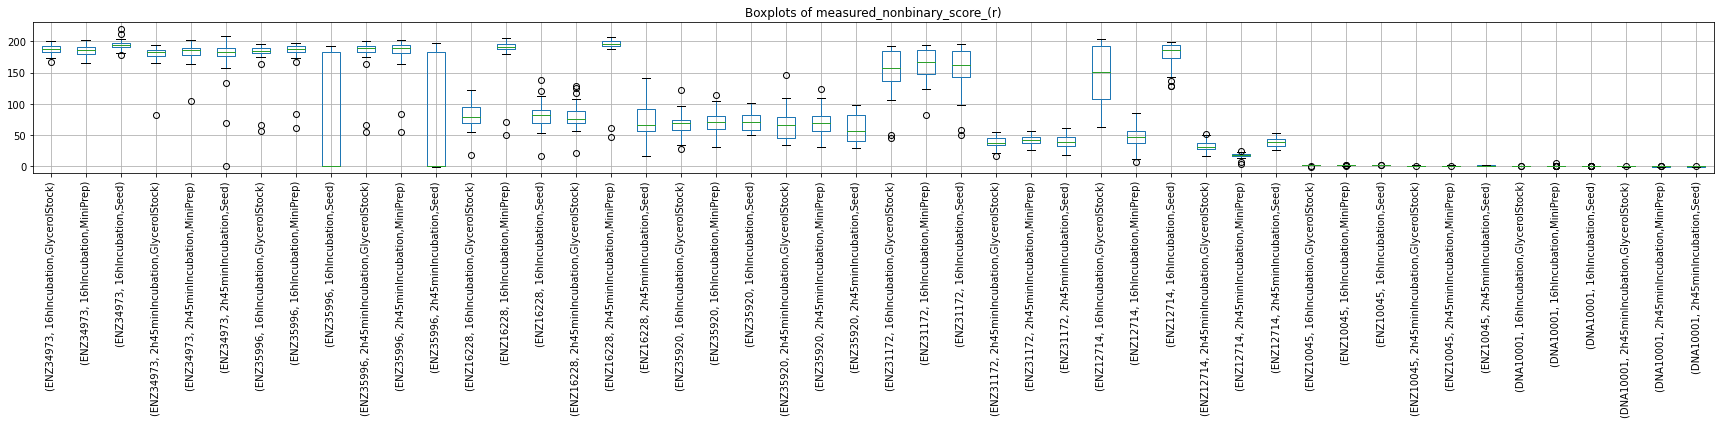

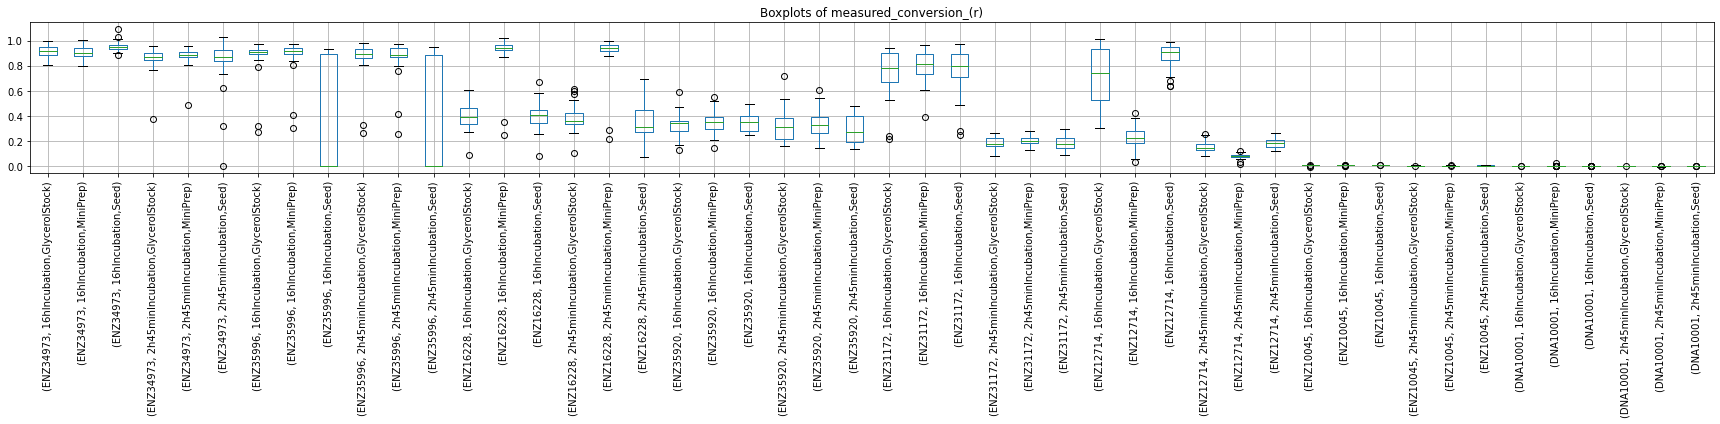

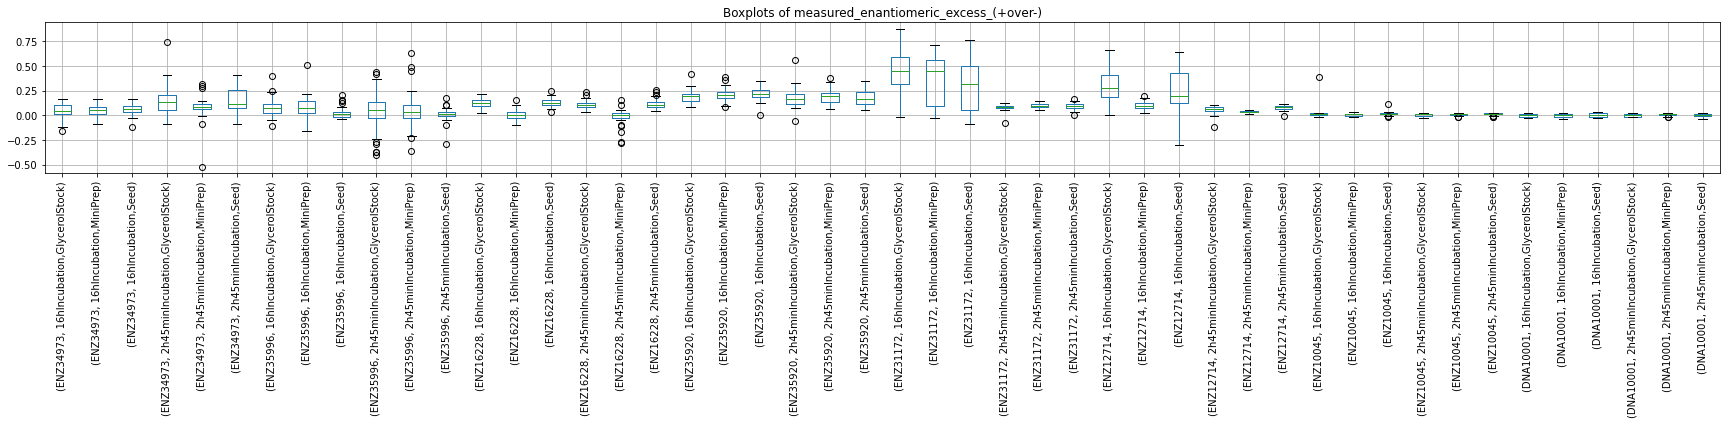

In [21]:
enz_list = variant_analytics.iloc[3:].enzyme_barcode.tolist()
print(enz_list)
boxplot_activity_all_variants_expcondition = analysis_pipeline.get_activity_correlation_boxplots(
    df, 
    metric_list=['measured_nonbinary_score_(r)', 'measured_conversion_(r)', 'measured_enantiomeric_excess_(+over-)'], 
    metricname_list=['RacemicProduct', 'RacemicConversion', 'ChiralEE'], 
    groupby=['enzyme_barcode', 'exp_condition'], 
    var_col_idx=0, 
    var_list=enz_list, 
    table_suffix=''
)
# boxplot_activity_all_variants_expcondition[0].savefig(f'{figure_folder}VQ-Retest5-BOXPLOT_ALL.png')

## Get individual boxplots of exp conditions within each variant

ENZ34973
Saved VQ-Retest5/BOXPLOT_ENZ34973_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ35996
Saved VQ-Retest5/BOXPLOT_ENZ35996_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ16228
Saved VQ-Retest5/BOXPLOT_ENZ16228_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ35920
Saved VQ-Retest5/BOXPLOT_ENZ35920_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ31172
Saved VQ-Retest5/BOXPLOT_ENZ31172_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ12714
Saved VQ-Retest5/BOXPLOT_ENZ12714_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ10045
Saved VQ-Retest5/BOXPLOT_ENZ10045_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
DNA10001
Saved VQ-Retest5/BOXPLOT_DNA10001_RacemicProduct_exp_condition-lcms_plate_(r).png to S3.
ENZ34973
Saved VQ-Retest5/BOXPLOT_ENZ34973_ChiralEE_exp_condition-lcms_plate_(r).png to S3.
ENZ35996
Saved VQ-Retest5/BOXPLOT_ENZ35996_ChiralEE_exp_condition-lcms_plate_(r).png to S3.
ENZ16228
Saved VQ-Retest5/BOXPLO

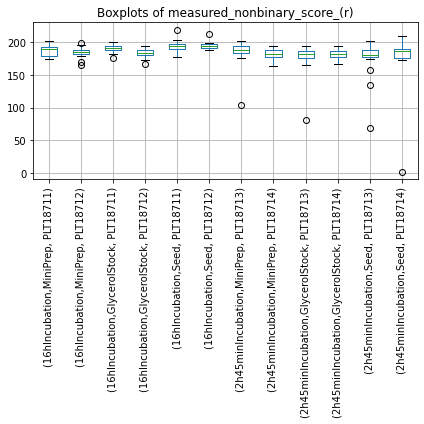

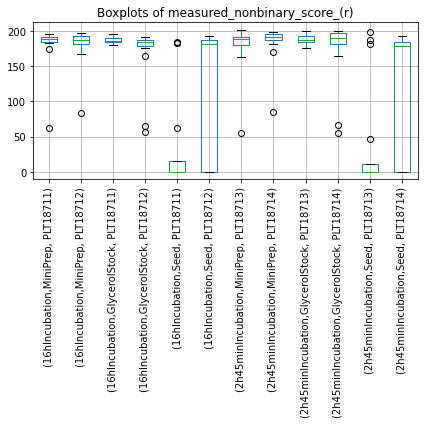

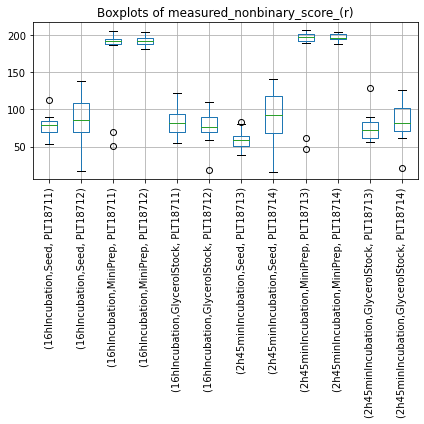

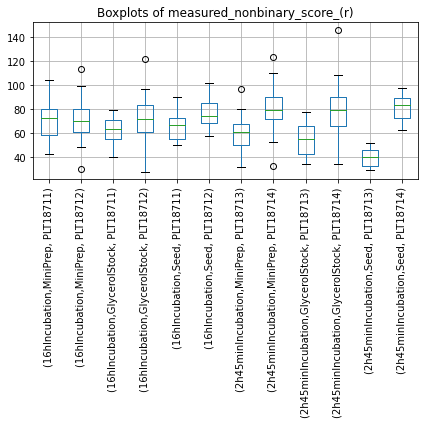

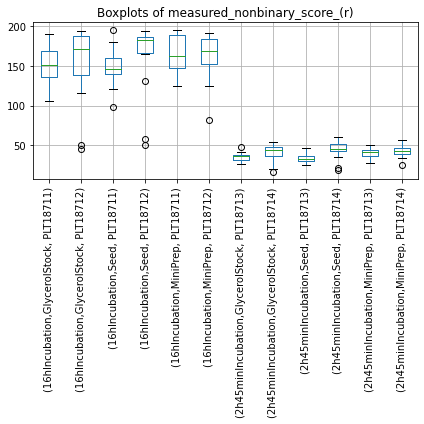

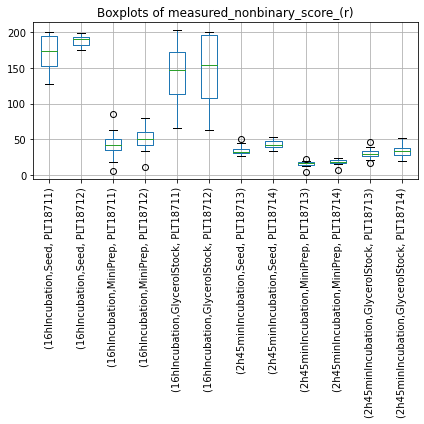

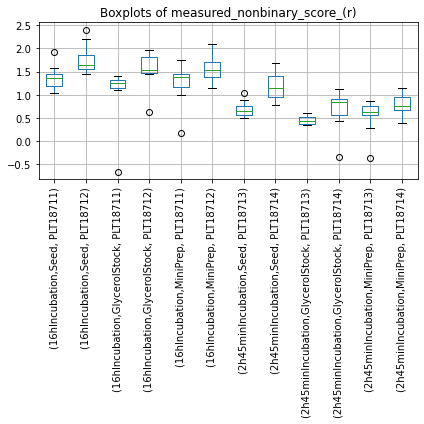

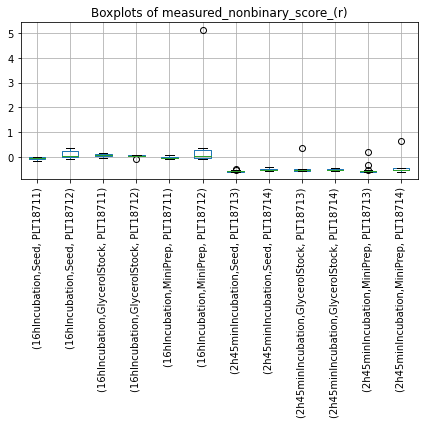

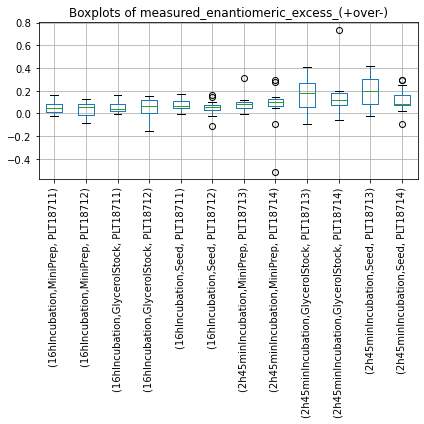

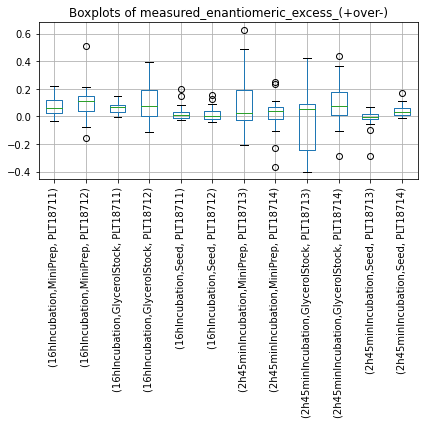

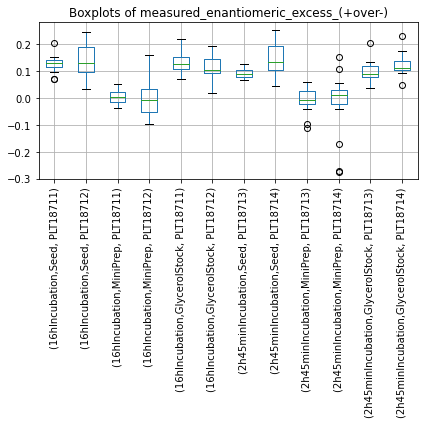

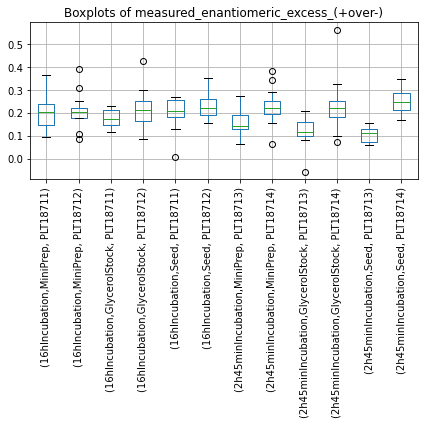

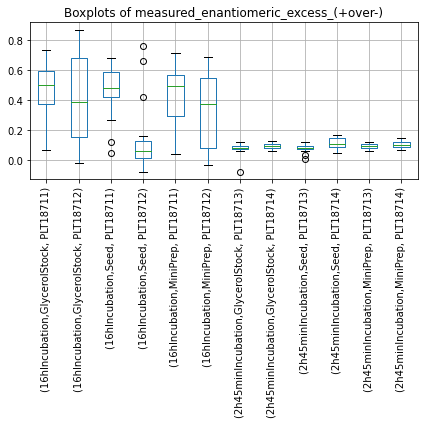

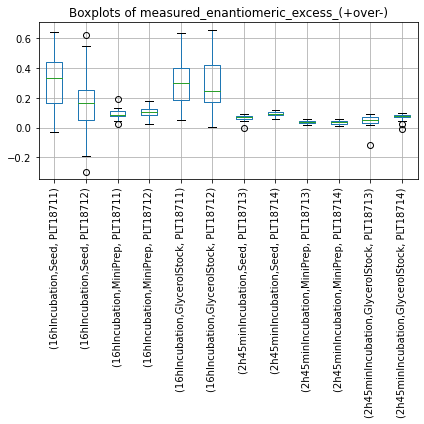

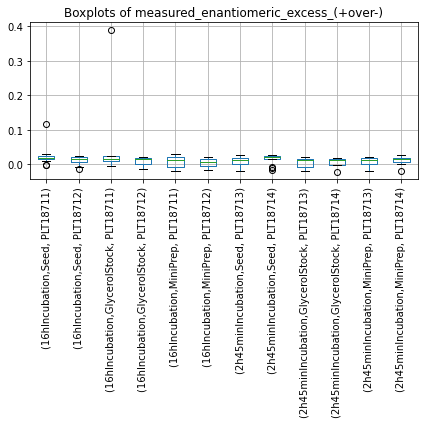

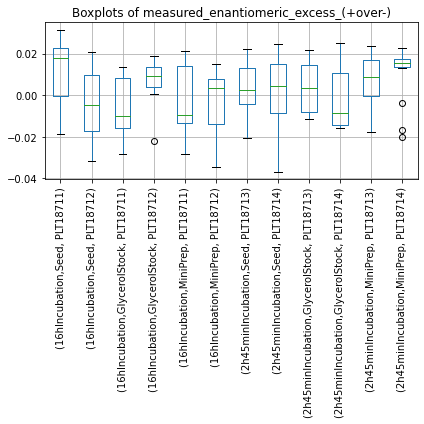

In [22]:
metric_list=['measured_nonbinary_score_(r)', 'measured_enantiomeric_excess_(+over-)']
metricname_list=['RacemicProduct', 'ChiralEE']

# get boxplots, split by enzyme variant
for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    for enz in enz_list:
        print(enz)
        variant_reps = df.loc[df['enzyme_barcode']==enz]
        boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
            variant_reps, 
            metric_list=[metric],
            metricname_list=[metricname],
            groupby=['exp_condition', 'lcms_plate_(r)'],
            fname_prefix=f'{enz}_'
        )

## Get boxplot across experiment conditions

In [ ]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
experiment_analytics_varonly = experiment_analytics.iloc[3:].copy()
experiment_analytics_varonly = experiment_analytics_varonly.loc[~experiment_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        experiment_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['exp_condition'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV']

# get boxplots, split by enzyme variant
experiment_analytics_noEV = experiment_analytics.iloc[3:].copy()
experiment_analytics_noEV = experiment_analytics_noEV.loc[~experiment_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        experiment_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['exp_condition'],
        fname_prefix='VAR-ONLY_'
    )

## Get boxplot across plates

In [ ]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
variant_plate_analytics_varonly = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_varonly = variant_analytics_varonly.loc[~variant_plate_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['lcms_plate_(r)'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV']

# get boxplots, split by enzyme variant
variant_plate_analytics_noEV = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_noEV = variant_plate_analytics_noEV.loc[~variant_plate_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['lcms_plate_(r)'],
        fname_prefix='VAR-ONLY_'
    )

## Get boxplot across experiment conditions AND plates

Saved VQ-Retest5/BOXPLOT_VAR-ONLY_RacemicProduct-NONHITRATE_plate_expcondition.png to S3.
Saved VQ-Retest5/BOXPLOT_VAR-ONLY_RacemicProduct-MEAN_plate_expcondition.png to S3.
Saved VQ-Retest5/BOXPLOT_VAR-ONLY_RacemicProduct-MEDIAN_plate_expcondition.png to S3.
Saved VQ-Retest5/BOXPLOT_VAR-ONLY_RacemicProduct-STDEV_plate_expcondition.png to S3.
Saved VQ-Retest5/BOXPLOT_VAR-ONLY_RacemicProduct-CV_plate_expcondition.png to S3.


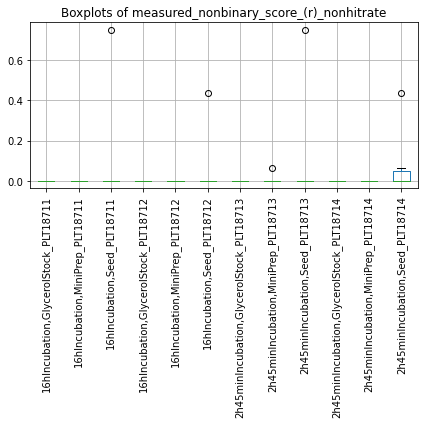

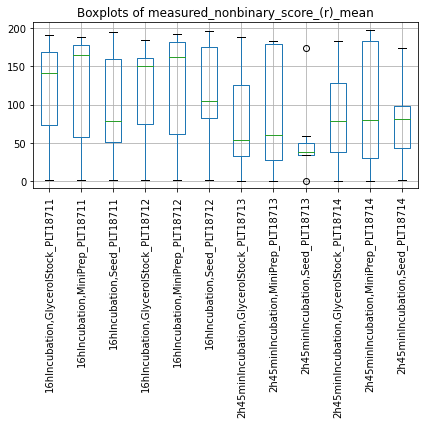

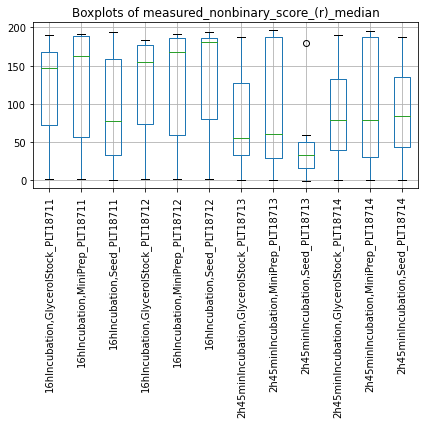

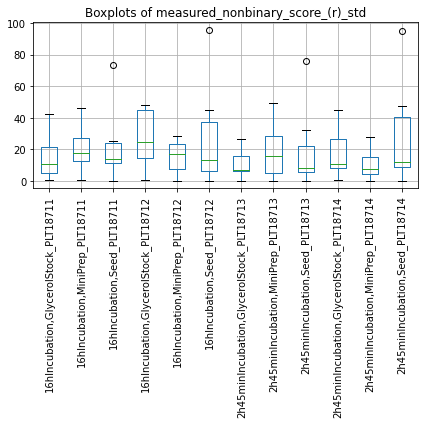

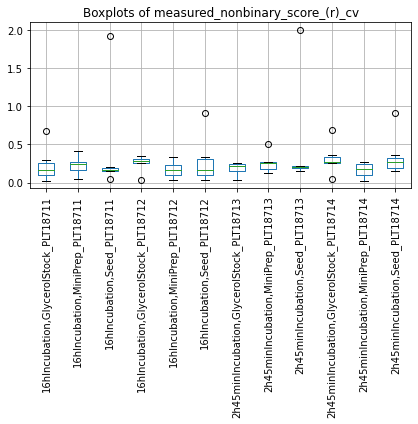

In [94]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
variant_plate_analytics_varonly = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_varonly = variant_plate_analytics_varonly.loc[~variant_plate_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['plate_expcondition'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV']

# get boxplots, split by enzyme variant
variant_plate_analytics_noEV = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_noEV = variant_plate_analytics_noEV.loc[~variant_plate_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['plate_expcondition'],
        fname_prefix='VAR-ONLY_'
    )

# Save dashboard contents to S3

In [24]:
# pickle analysis pipeline s3 folder
filename = f'{s3_subfolder}dashboard_contents.pkl'

# SAVE DASHBOARD CONTENTS
upload_to_s3(s3_bucket, filename, analysis_pipeline.dashboard_contents)  

# # LOAD MODEL
# dashboard_contents_unpickled = download_from_s3(s3_bucket, filename)
# print(dashboard_contents_unpickled)

# Get Analytics Dashboard

## Initialize Analytics Pipeline object & get panel columns

In [ ]:
s3_subfolder = f'VQ-Retest5/' 
exp_workflow = ['WF10198']
table = 'combi_analytics_table' # 'lcms_detections' # 
analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    get_dashboard_panel=False,
    save_plots_to_s3=True
)

# fetch panel columns
panel_columns = analysis_pipeline.fetch_saved_panel_data()

In [ ]:
pn.template.FastListTemplate(
    site="Panel", 
    title=f"{s3_subfolder}Dev Analytics", 
    main=panel_columns, 
    main_max_width="1760px",
)#.servable();

# Manual Analysis

## Comparison to Phoenix Data

In [56]:
exp_workflow_phnx = ['WF10125','WF10128','WF10130','WF10132', 'WF10134', 'WF10136', 'WF10139', 'WF10144', 'WF10149', 'WF10157', 'WF10158', 'WF10163', 'WF10169', 'WF10173', 'WF10181']  # None # 
df_phnx = analysis_pipeline.load_data(table, exp_workflow=exp_workflow_phnx)
enz_list_varonly = [enz for enz in list(set(enz_list)) if enz not in ['DNA10001', 'ENZ10045']]
df_phnx_varonly = df_phnx.loc[df_phnx.enzyme_barcode.isin(enz_list_varonly)].reset_index(drop=True)

executing query: SELECT "id", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "maldi_run", "lcms_C18_run", "lcms_chiral_run", "maldi_plate_(r)", "maldi_address_(r)", "lcms_plate_(r)", "lcms_address_(r)", "source_plate_(r)", "source_address_(r)", "maldi_plate_(+)", "maldi_address_(+)", "lcms_plate_(+)", "lcms_address_(+)", "source_plate_(+)", "source_address_(+)", "maldi_plate_(-)", "maldi_address_(-)", "lcms_plate_(-)", "lcms_address_(-)", "source_plate_(-)", "source_address_(-)", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "mutations", "hamming", "reference_enzyme", "substrate_barcode_(r)", "substrate_barcode_(+)", "substrate_barcode_(-)", "substrate_smiles_(r)", "substrate_smiles_(+)", "substrate_smiles_(-)", "substrate_concentration_(r)", "substrate_concentration_(+)", "substrate_concentration_(-)", "predicted_binary_score_(r)", "predicted_nonbinary_score_(r)", "measured_nonbinary_score_(r)", "measured_nonbinary_sum_(r)", "measured_conversio

In [60]:
# combine Retest 5 and Phoenix dataset
df_all = pd.concat([df_phnx_varonly, df]).reset_index(drop=True)

# replace NaN exp_condition values with ''
df_all.loc[df_all.exp_condition.isnull(), 'exp_condition'] = ''

ENZ12714
ENZ16228


/Users/charmaine/Documents/projects/ml-preprocessing/utils/visualization_utils.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/charmaine/Documents/projects/ml-preprocessing/utils/visualization_utils.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/charmaine/Documents/projects/ml-preprocessing/utils/visualization_utils.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/charmaine/Documents/projects/ml-preprocessing/utils/visualization_utils.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ENZ35996
ENZ35920
ENZ31172


/Users/charmaine/Documents/projects/ml-preprocessing/utils/visualization_utils.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/charmaine/Documents/projects/ml-preprocessing/utils/visualization_utils.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ENZ34973


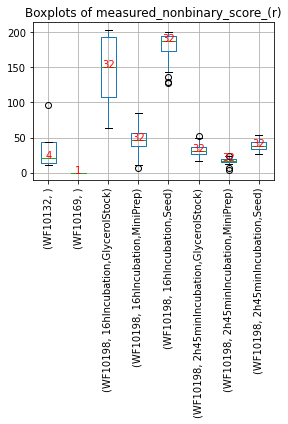

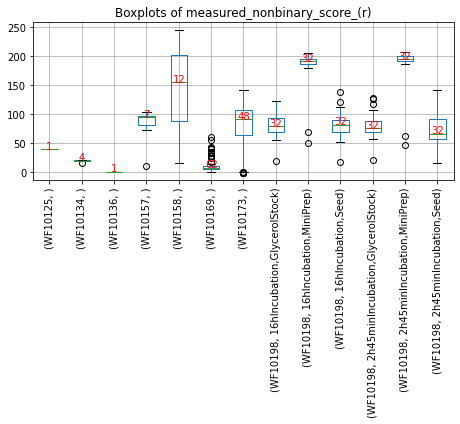

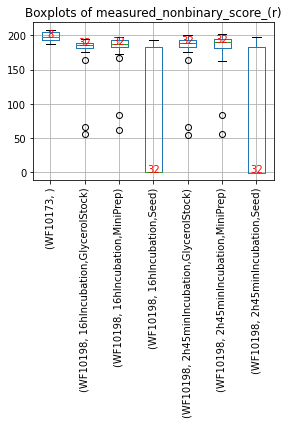

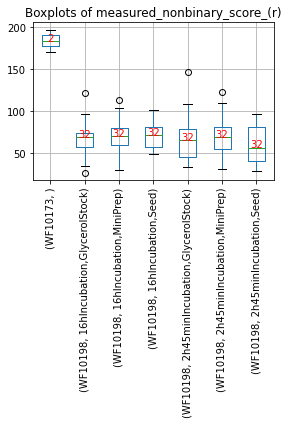

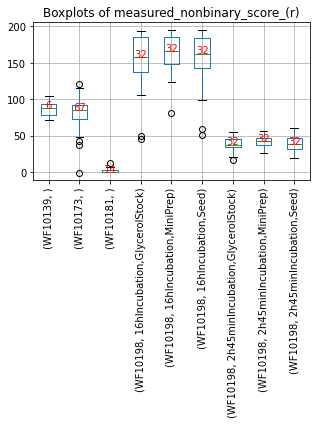

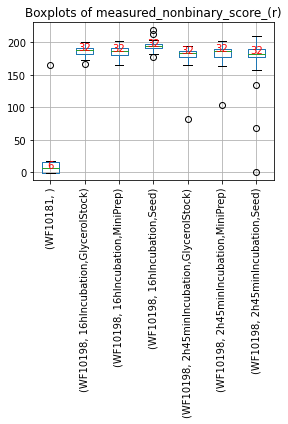

In [63]:
from utils.visualization_utils import plot_boxplot

for enz in enz_list_varonly:
    print(enz)
    df_enz = df_all.loc[df_all.enzyme_barcode==enz]
    boxplot_list_enz = plot_boxplot(df_enz, ['measured_nonbinary_score_(r)'], groupby=['exp_workflow_barcode', 'exp_condition'], showplot=True, show_n=True)

In [76]:
df[['lcms_plate_(r)', 'seed_plate']].drop_duplicates(['lcms_plate_(r)', 'seed_plate']).sort_values(by='lcms_plate_(r)').reset_index(drop=True)

,lcms_plate_(r),seed_plate
0,PLT18711,PLT18636
1,PLT18712,PLT18635
2,PLT18713,PLT18636
3,PLT18714,PLT18635
